In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [3]:

df = pd.read_json("scirate_data.json")
df.head()

df['date_YY_MM'] = df['arxiv_id'].apply(lambda x: str(x)[0:2] + "-" + str(x)[2:4])
df['date_M'] = df['arxiv_id'].apply(lambda x: (int(str(x)[0:2]) - 14) * 12 + int(str(x)[2:4]) - 1)
df['date_Y'] = df['arxiv_id'].apply(lambda x: (int(str(x)[0:2]) - 14))

Note that the scites are skewed due to the growing popularity of the site over the years. We will rescale the scites so papers have comparable weights.

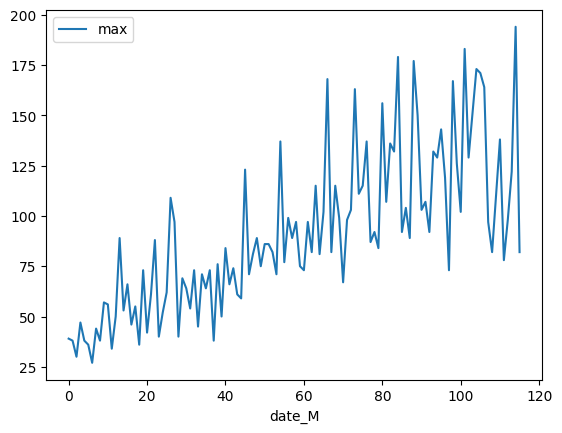

In [4]:
df.groupby('date_M').agg([np.max])['scites'].plot()
plt.show()

In [5]:
scale_factors = np.max(df.groupby('date_Y')['scites'].agg([np.mean])['mean']) / df.groupby('date_Y')['scites'].agg([np.mean])
df = df.merge(scale_factors, on='date_Y')
df = df.rename(columns={'mean':'scites_scale_factor'})
df['scites_scaled'] = df['scites'] * df['scites_scale_factor']

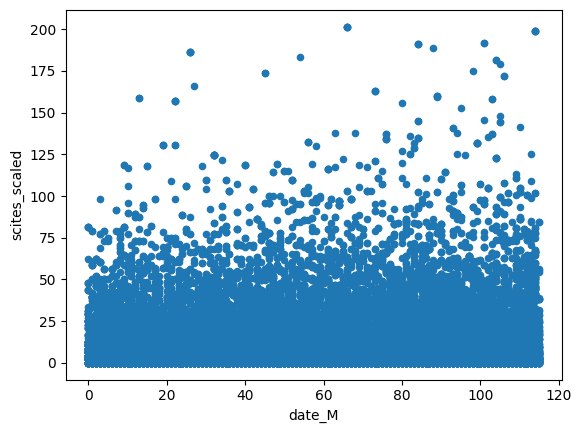

In [6]:
df.plot(kind='scatter', x='date_M', y='scites_scaled')
plt.show()

Next, we'll use NLP to add features about the Title and Abstracts. We will use a BERT model and tensorflow, specifically trained on scientific text.

In [1]:
from transformers import *

tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')

/home/alexander/Documents/GitHub/scirate_fun/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /home/alexander/.cache/huggingface/hub/models--allenai--scibert_scivocab_uncased/snapshots/24f92d32b1bfb0bcaf9ab193ff3ad01e87732fc1/config.json
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivocab_uncased",
  "attention_probs_dropout

ImportError: 
AutoModel requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.


In [27]:
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser


abstracts = df['abstract']
titles = df['title']

t_abstracts = [simple_preprocess(a) for a in abstracts]
t_titles = [simple_preprocess(t) for t in titles]

Next we remove the stopwords and create phrases from the physics jargon that shouldn't be split up.

In [26]:
from gensim.parsing.preprocessing import STOPWORDS

f_t_abstracts = [[t for t in a if t not in STOPWORDS] for a in t_abstracts]
f_t_titles = [[t for t in title if t not in STOPWORDS] for title in t_titles]

# # Detect and create bigrams
# def phrase(tokens):
#     bigram_model = Phrases([tokens], min_count=1, threshold=5)
#     bigram_phraser = Phraser(bigram_model)
#     bigram_tokens = bigram_phraser[tokens]
#     return bigram_tokens

# b_f_t_abstracts = [phrase(tokens) for tokens in f_t_abstracts]
# b_f_t_titles = [phrase(tokens) for tokens in f_t_titles]

Next we lemmatize!

In [36]:
from nltk import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

l_f_t_abstracts = [[lemmatizer.lemmatize(t) for t in abstract] for abstract in f_t_abstracts]
l_f_t_titles = [[lemmatizer.lemmatize(t) for t in title] for title in f_t_titles]

Make a dictionary and corpus

In [40]:
from gensim.corpora import Dictionary

dictionary_title = Dictionary(l_f_t_titles)
dictionary_abstract = Dictionary(l_f_t_abstracts)

In [42]:
corpus_title = [dictionary_title.doc2bow(title) for title in l_f_t_titles]
corpus_abstract = [dictionary_abstract.doc2bow(abstract) for abstract in l_f_t_abstracts]


With our data preprocessed, we can now add a word embedding. We choose SCIBERT for the large amount of technical jargon that will be present.